In [160]:
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter 
import scipy
import json
import torchvision.transforms.functional as F
from matplotlib import cm as CM
from image import *
from model import CSRNet
import cmath
import torch
# from sklearn.metrics import mean_squared_error
%matplotlib inline

In [161]:
from torchvision import datasets, transforms
transform=transforms.Compose([
                       transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
                   ])

In [162]:
root = ''

In [163]:
#now generate the ground truth
part_A_train = os.path.join(root,'dataset_train','images')
part_A_test = os.path.join(root,'dataset_test','images')
# part_B_train = os.path.join(root,'part_B_final/train_data','images')
# part_B_test = os.path.join(root,'part_B_final/test_data','images')
path_sets = [part_A_test]

In [164]:
img_paths = []
for path in path_sets:
    # print(path)
    for img_path in glob.glob(os.path.join(path, '*.png')):
        
        img_paths.append(img_path)

In [165]:
model = CSRNet()

In [166]:
model = model.cuda()

In [167]:
checkpoint = torch.load('checkpoints/5model_best.pth.tar')

In [ ]:
model.load_state_dict(checkpoint['state_dict'])

In [169]:
mae = 0
mse = 0
print(len(img_paths))
errors = []
gt = []
error_number = []
number_error = []
for i in xrange(1):
    img = 255.0 * F.to_tensor(Image.open(img_paths[i]).convert('RGB'))

    img[0,:,:]=img[0,:,:]-92.8207477031
    img[1,:,:]=img[1,:,:]-95.2757037428
    img[2,:,:]=img[2,:,:]-104.877445883
    img = img.cuda()
    img = transform(Image.open(img_paths[i]).convert('RGB')).cuda()
    gt_file = h5py.File(img_paths[i].replace('.png','.h5').replace('images','ground_truth'),'r')
    groundtruth = np.asarray(gt_file['density'])
    output = model(img.unsqueeze(0))
    error = output.detach().cpu().sum().numpy()-np.sum(groundtruth)
    errors.append(abs(error))
    gt.append(np.sum(groundtruth))
    error_number.append(abs(error)/np.sum(groundtruth))
    number_error.append(np.sum(groundtruth)/abs(error))
    mae += abs(error)
    mse += error ** 2
    
    # print img_paths[i],output.detach().cpu().sum().numpy(), np.sum(groundtruth), error
    
print mae/len(img_paths)
mse = cmath.sqrt(mse/len(img_paths))
print mse
# print(error_number)


201
0.0241087728472
(0.341800846353+0j)


In [172]:
def tp(out, score):
    l0 = 128 * 128 - len(score)
    tp, fn = 0, 0
    fp, tn = 0, 0
    for i in out:
        if i in score or i-1 in score:
            tp += 1
    fn = len(score) - tp
    fp = len(out) - tp
    tn = l0 - fp
    tpr = tp * 1.0/ (tp + fn)
    fpr = fp * 1.0 / (fp + tn)
    if tp + fp != 0:
        precision = tp * 1.0/ (tp + fp)
    else:
        precision = 1.0
    recall = tp * 1.0/ (tp + fn)
    accuracy = (tp + tn) * 1.0 / (tp + fn + fp + tn)
    return tpr, fpr, precision, recall, accuracy

In [173]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
import heapq
f = np.array([[1,1,1,1,1,1,1,1],
              [1,1,1,1,1,1,1,1],
              [1,1,1,1,1,1,1,1],
              [1,1,1,1,1,1,1,1],
              [1,1,1,1,1,1,1,1],
              [1,1,1,1,1,1,1,1],
              [1,1,1,1,1,1,1,1],
              [1,1,1,1,1,1,1,1],
              ])
def cov2(img,f,strde):
    inw,inh = img.shape
    w,h=f.shape
    outw = (inw -w )/strde + 1
    outh = (inh -h )/strde + 1
    arr = np.zeros(shape=(outw, outh))
    for g in range(outh):
       for t in range(outw):
          s = 0
          for i in range(w):
              for j in range(h):
                  s+=img[i+g*strde][j+t*strde]*f[i][j]
                  # s = img[i][j] * f[i][j]
          arr[g][t]=s
    return arr

mae = 0
mse = 0
print(len(img_paths))
tprs, fprs, pres, recalls, accs = 0, 0 ,0, 0, 0
errors = []
gt = []
error_number = []
number_error = []
from compiler.ast import flatten
for i in xrange(len(img_paths)):
    img = 255.0 * F.to_tensor(Image.open(img_paths[i]).convert('RGB'))

    img[0,:,:]=img[0,:,:]-92.8207477031
    img[1,:,:]=img[1,:,:]-95.2757037428
    img[2,:,:]=img[2,:,:]-104.877445883
    img = img.cuda()
    img = transform(Image.open(img_paths[i]).convert('RGB')).cuda()
    gt_file = h5py.File(img_paths[i].replace('.png','.h5').replace('images','ground_truth'),'r')
    groundtruth = np.asarray(gt_file['density'])
    output = model(img.unsqueeze(0))
    # print(output.type())
    # print(output.detach().cpu())
    y = []
    out = output.detach().cpu().numpy()
    out = out[0][0]
    out = out.tolist()
    out = flatten(out)
    # print(out)
    # print(len(out))
    # print(groundtruth)
    score = cov2(groundtruth,f,8)
    score = score.tolist()
    score = flatten(score)
    num_score = int(sum(score))
    num_out = int(sum(out))
    # print(num_score, num_out)
    re1 = map(score.index, heapq.nlargest(num_score, score)) 
    re2 = map(out.index, heapq.nlargest(num_out, out)) 
    

    score = list(re1)
    out = list(re2)
    # print(tp(out, score))
    tpr, fpr, precision, recall, accuracy = tp(out, score)
    tprs += tpr
    fprs += fpr
    pres += precision
    recalls += recall
    accs += accuracy
    print(tpr, fpr, precision, recall, accuracy)
    error = output.detach().cpu().sum().numpy()-np.sum(groundtruth)
    errors.append(abs(error))
    gt.append(np.sum(groundtruth))
    error_number.append(abs(error)/np.sum(groundtruth))
    number_error.append(np.sum(groundtruth)/abs(error))
    mae += abs(error)
    mse += error ** 2
    
    # print img_paths[i],output.detach().cpu().sum().numpy(), np.sum(groundtruth), error

print('tpr', tprs / len(img_paths))
print('fpr', fprs / len(img_paths))
print('pres', pres / len(img_paths))
print('recall', recalls / len(img_paths))
print('accuracy', accs / len(img_paths))

print mae/len(img_paths)
mse = cmath.sqrt(mse/len(img_paths))
print mse

201
(0.75, 0.0007338551859099804, 0.6666666666666666, 0.75, 0.998779296875)
(0.9375, 0.0004892367906066536, 0.7894736842105263, 0.9375, 0.9993896484375)
(0.9090909090909091, 0.0, 1.0, 0.9090909090909091, 0.9998779296875)
(0.5522388059701493, 0.0017772874915732058, 0.5606060606060606, 0.5522388059701493, 0.99639892578125)
(0.5333333333333333, 0.0009163663021565154, 0.34782608695652173, 0.5333333333333333, 0.9986572265625)
(0.38333333333333336, 0.0023891203136486155, 0.3709677419354839, 0.38333333333333336, 0.995361328125)
(0.6704545454545454, 0.0013500245459008345, 0.7283950617283951, 0.6704545454545454, 0.99688720703125)
(0.912751677852349, 0.0017862642439174623, 0.8242424242424242, 0.912751677852349, 0.9974365234375)
(1.0508474576271187, 0.0005513016845329249, 0.8732394366197183, 1.0508474576271187, 0.9996337890625)
(0.9448818897637795, 0.00018453589223103894, 0.975609756097561, 0.9448818897637795, 0.9993896484375)
(0.5769230769230769, 0.0016584766584766585, 0.6896551724137931, 0.5769

[0.17410677671432515, 0.27885795362067944, 0.028302972966974746, 0.015377044677734375, 0.24380576610565158, 0.0075760513055515288, 0.29252637516368485, 0.085806008153313407, 0.095170338948568092, 0.36109173391747662, 0.28684960878812377, 0.26321066579511088, 0.13113886515299453, 0.15162066050938208, 2.1029027303059893, 0.27309383045543334, 0.081536388397216983, 0.89278366986442936, 0.0025285637896990789, 0.27164896523080195, 0.0050815809641449067, 1.4578304290771484, 0.2430486679077147, 0.090401294184666303, 0.3449222858135515, 0.082833353678385582, 1.0416988645281111, 0.29551334381103517, 0.4335377216339108, 0.18653106689453114, 0.15667219161987334, 0.10699019321175508, 0.067747497558594411, 0.10981169990871305, 0.077873653835720272, 0.091203811320853131, 0.084472207462086391, 0.82331536032936847, 0.21141555786132812, 0.26693546528718887, 2.2123339970906573, 0.0752256566827946, 0.02801427841186558, 0.2726763989551958, 0.1096426067930277, 0.26608195585363054, 0.3608057975769044, 0.1858

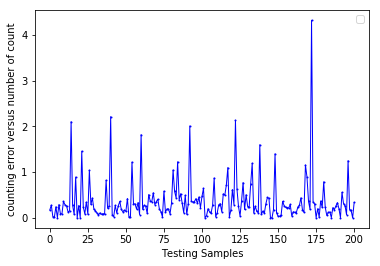

In [45]:
x = range(0, 201)
print(error_number)
plt.plot(x, error_number,  linewidth=1,color='blue',marker='o', markerfacecolor='blue',markersize=1)
plt.xlabel('Testing Samples')
plt.ylabel('counting error versus number of count')
# plt.xlim(-0.5,11)
# plt.title('Interesting Graph\nCheck it out')
plt.legend()
plt.savefig("error_number.png",dpi=600)

In [ ]:
x = range(0, 201)
print(number_error)
plt.plot(x, number_error, linewidth=1,color='blue',marker='o', markerfacecolor='blue',markersize=1)
plt.xlabel('Testing Samples')
plt.ylabel('number of count versus counting error')
# plt.xlim(-0.5,11)
# plt.title('Interesting Graph\nCheck it out')
plt.legend()
plt.savefig("number_error.png",dpi=600)

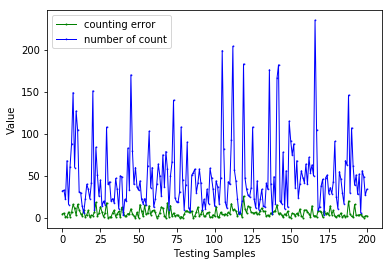

In [31]:
plt.plot(x, errors, label='counting error', linewidth=1,color='green',marker='o', markerfacecolor='green',markersize=1)
plt.plot(x, gt, label='number of count', linewidth=1,color='blue',marker='v', markerfacecolor='blue',markersize=1)

plt.xlabel('Testing Samples')
plt.ylabel('Value')


plt.legend()
plt.savefig("versus.png",dpi=600)

In [ ]:
x = range(0, 201)
print(errors)
plt.plot(x, errors, label='MAE', linewidth=1,color='blue',marker='o', markerfacecolor='blue',markersize=1)
plt.xlabel('Testing Sample')
plt.ylabel('Estimated Error')
# plt.xlim(-0.5,11)
# plt.title('Interesting Graph\nCheck it out')
plt.legend()
plt.savefig("errors.png",dpi=600)

In [81]:
import json
import os
from numpy import *
nums = []
filenames = os.listdir('dataset_train/density/')
for file in filenames:
    img_path = "dataset_train/images/"+file
    img_path = img_path.replace("png", 'json')
    f = open(img_path)
    data = json.load(f)
    roilist = data['roilist']
    nums.append(len(roilist))
    
print(len(nums))
print mean(nums)
print min(nums)
print max(nums)


658
36.9376899696
1
532


In [76]:
import json
import os
from numpy import *
nums = []
filenames = os.listdir('single/density/')
for file in filenames:
    img_path = "single/images/"+file
    img_path = img_path.replace("png", 'json')
    f = open(img_path)
    data = json.load(f)
    roilist = data['roilist']
    nums.append(len(roilist))
    
print(len(nums))
print mean(nums)
print min(nums)
print max(nums)


859
83.6519208382
4
632


In [80]:
# import json
# import os
# from numpy import *
# # nums = []
filenames = os.listdir('single_random_4/test/density/')
for file in filenames:
    img_path = "single_random_4/test/images/"+file
    img_path = img_path.replace("png", 'json')
    f = open(img_path)
    data = json.load(f)
    roilist = data['roilist']
    nums.append(len(roilist))
    
print(len(nums))
print mean(nums)
print min(nums)
print max(nums)

859
49.6088474971
1
532


In [82]:
filenames = os.listdir('single_random_4/train/density/')
for file in filenames:
    img_path = "single_random_4/train/images/"+file
    img_path = img_path.replace("png", 'json')
    f = open(img_path)
    data = json.load(f)
    roilist = data['roilist']
    nums.append(len(roilist))
    
print(len(nums))
print mean(nums)
print min(nums)
print max(nums)

1316
53.4331306991
1
612


In [83]:
filenames = os.listdir('single_train/density/')
for file in filenames:
    img_path = "single_train/images/"+file
    img_path = img_path.replace("png", 'json')
    f = open(img_path)
    data = json.load(f)
    roilist = data['roilist']
    nums.append(len(roilist))
    
print(len(nums))
print mean(nums)
print min(nums)
print max(nums)

2075
65.4443373494
1
632
